<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。  
　　　ただし、死亡数は一旦死亡率を求め計算します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [15]:
# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )
library( fable )
library( dplyr )

# ネット上のファイル読み込み
repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) |>           # ＴＳＩＢＢＬＥライブラリに変換
  mutate( Dr = Death / Total ) ->         # 死亡率の計算
pop_tsibble3

# 手順２　データの可視化

まず、データをプロットしてみます。

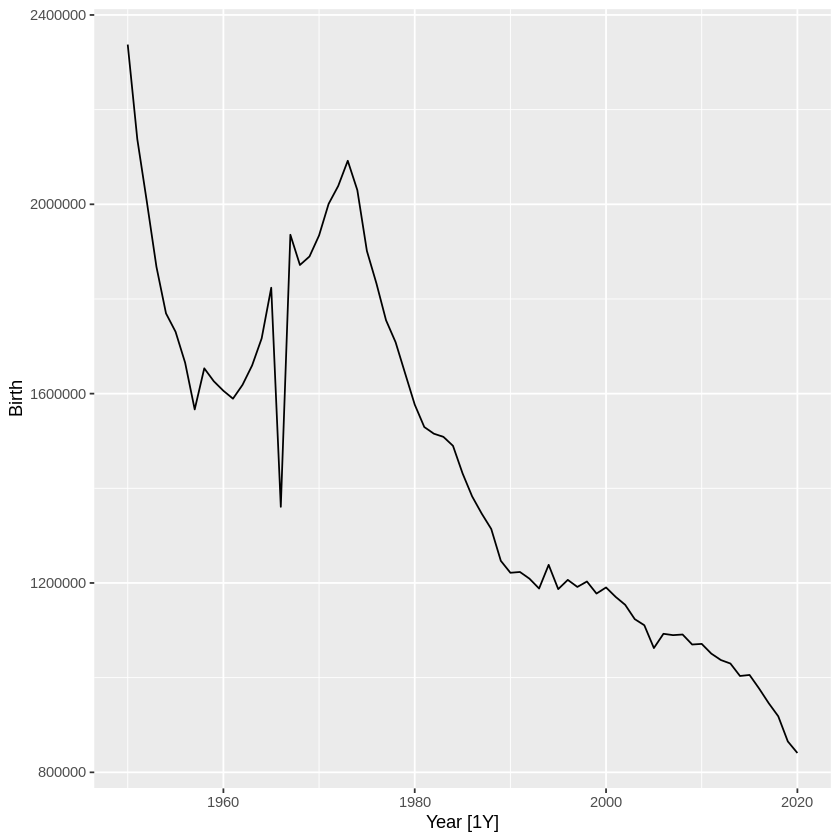

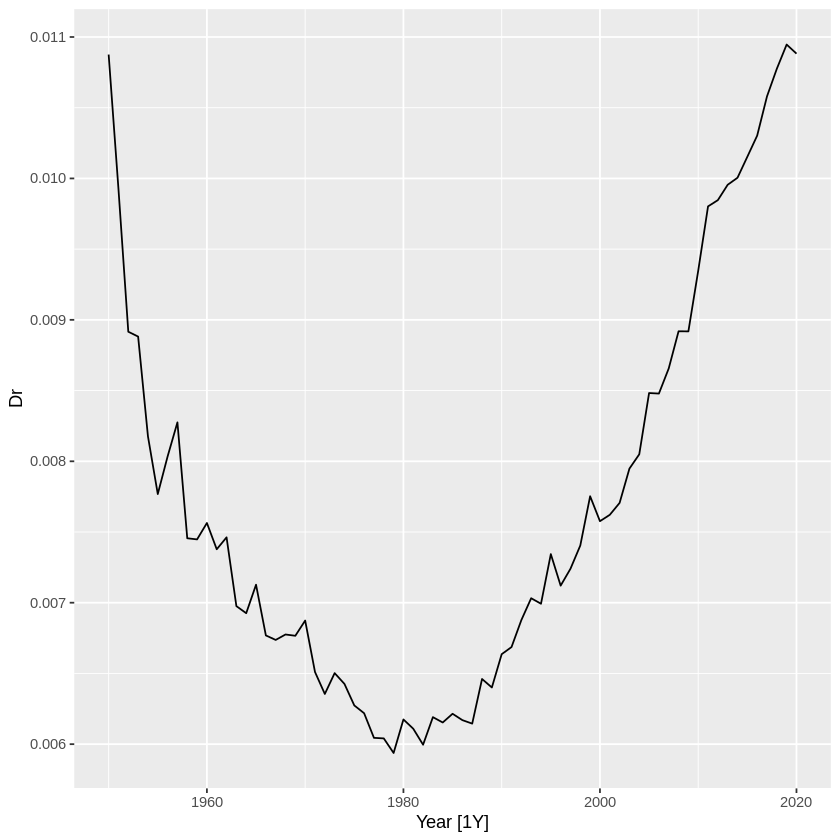

In [16]:
# 出生数、死亡率のグラフ
pop_tsibble3 |>
  autoplot( Birth )
pop_tsibble3 |>
  autoplot( Dr )

次に、自己相関を確認してみます。

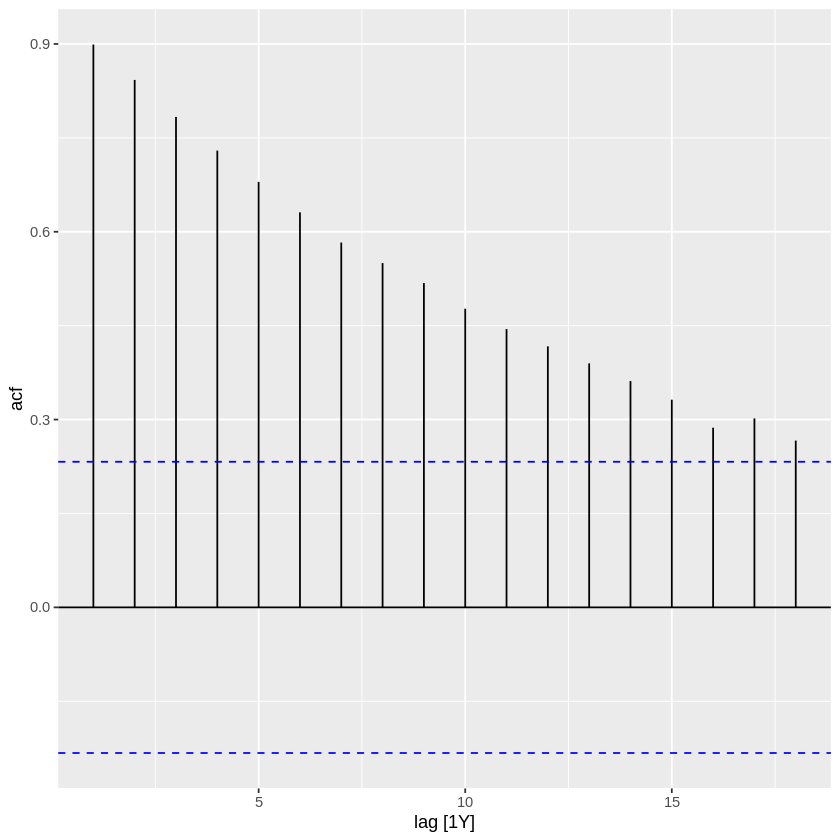

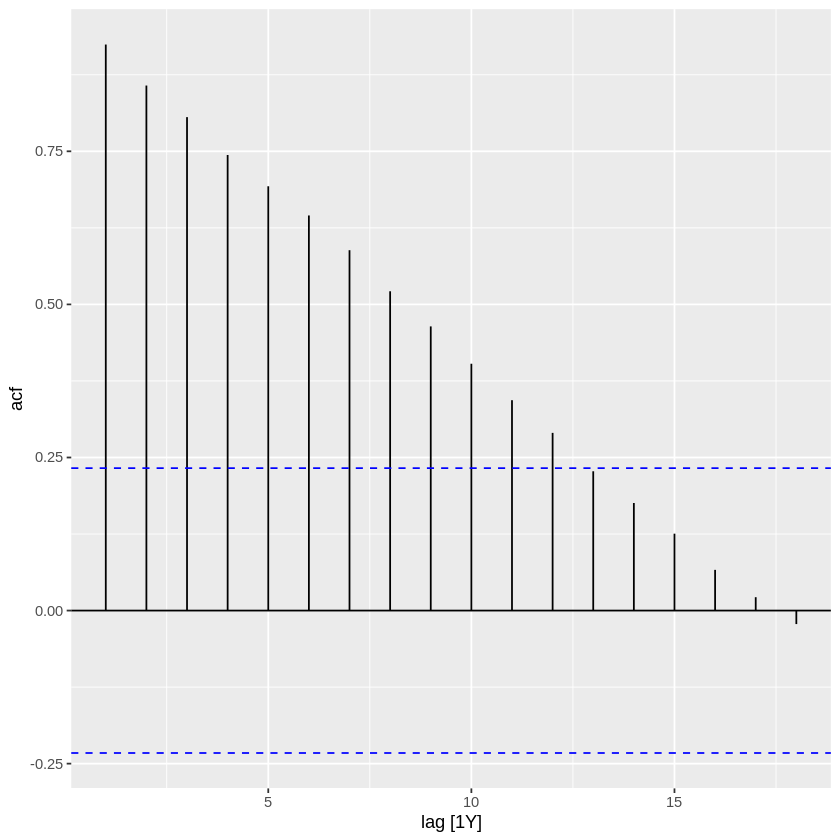

In [17]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble3 |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble3 |>
  ACF( log( Dr )) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

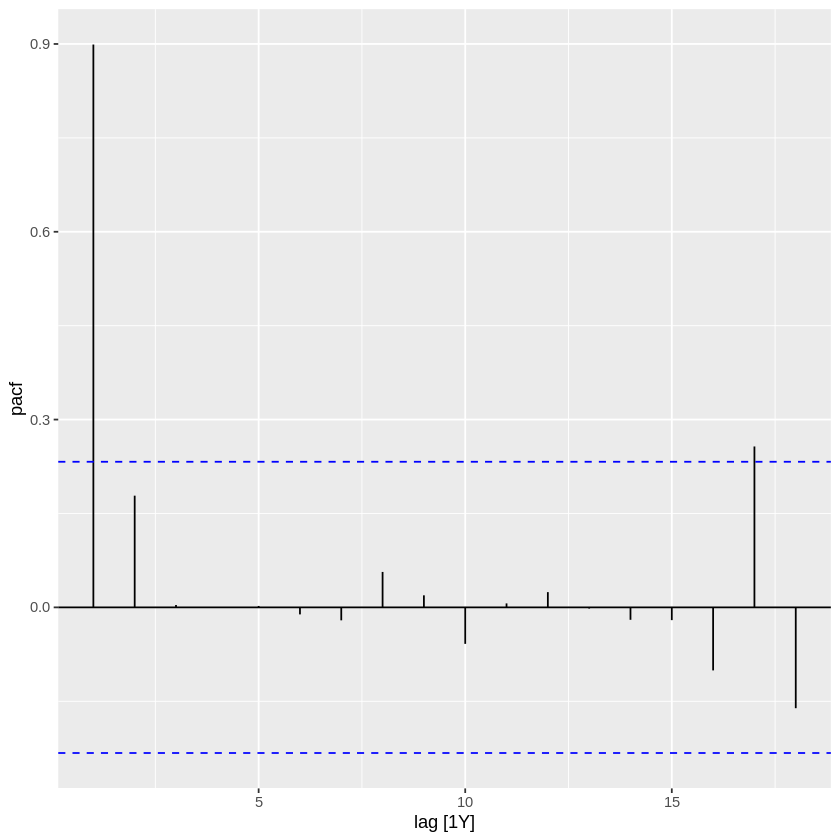

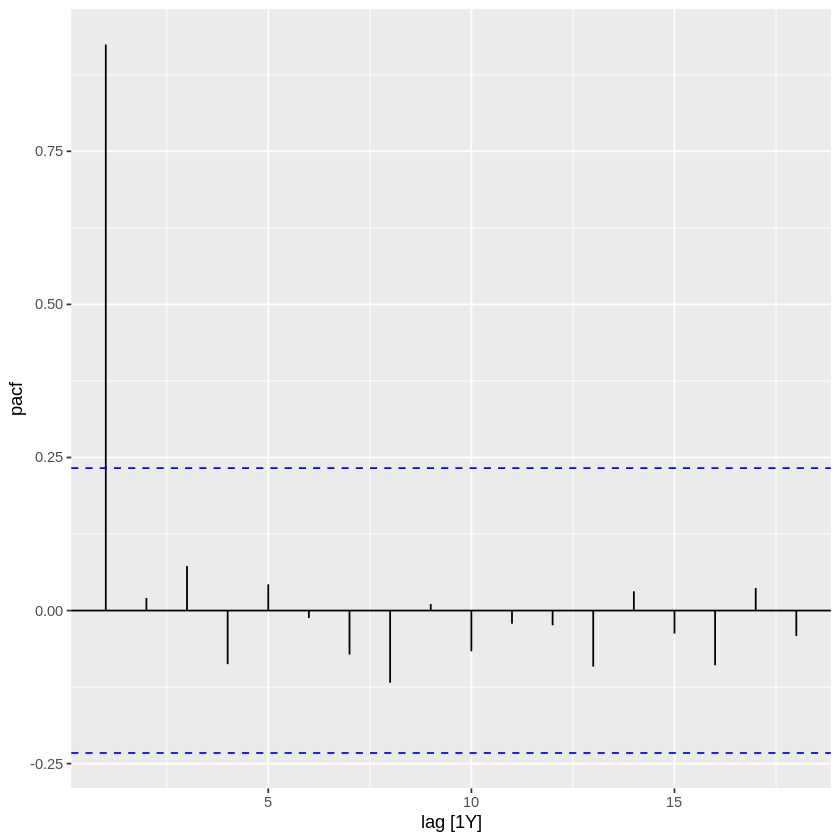

In [18]:
# 偏自己相関のグラフ
pop_tsibble3 |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble3 |>
  PACF( log( Dr )) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [19]:
# 学習データと予測データ
prow_test2 = 6
prow_train2 = nrow( pop_tsibble3 ) - prow_test2

pop_tsibble3 |>
  tail( n = prow_test2 ) ->
pop_test3

pop_tsibble3 |>
  head( n = prow_train2 ) ->
pop_train3

# 手順４　ＡＲＩＭＡモデルによる予測

学習データを使ってＡＲＩＭＡモデルを推定していきます。  
まず、出生についてモデルを自動推定させ、ＡＩＣが＋２までのモデルを候補にします。

In [20]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train3 |>
    model(
      arima = ARIMA( Birth,
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaB

max_AICB = min( trace_arimaB$AIC ) + 2
trace_arimaB |>
  filter( AIC < max_AICB ) 

Warning message:
“31 parsing failures.
row col expected actual         file
 14 AIC a number    Inf literal data
 15 AIC a number    Inf literal data
 16 AIC a number    Inf literal data
 17 AIC a number    Inf literal data
 18 AIC a number    Inf literal data
... ... ........ ...... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(1,1,0)(0,0,0)[1]+c",1661.006
"ARIMA(3,1,0)(0,0,0)[1]+c",1661.357
"ARIMA(4,1,0)(0,0,0)[1]+c",1660.440
"ARIMA(5,1,0)(0,0,0)[1]+c",1661.660
"ARIMA(2,1,1)(0,0,0)[1]+c",1661.718
"ARIMA(3,1,1)(0,0,0)[1]+c",1660.910
"ARIMA(0,1,2)(0,0,0)[1]+c",1659.753
"ARIMA(4,1,0)(0,0,0)[1]",1660.324
"ARIMA(5,1,0)(0,0,0)[1]",1661.303


列挙されたモデルで６年後までを予測し、  
２０２０年の実測した出生数に最も近いモデルを採用することにします。

In [21]:
pop_train3 |>
  model(
    arimaB110 = ARIMA( Birth ~ 0 + pdq( 1, 1, 0 )),
    arimaB310 = ARIMA( Birth ~ 0 + pdq( 3, 1, 0 )),
    arimaB410 = ARIMA( Birth ~ 0 + pdq( 4, 1, 0 )),
    arimaB510 = ARIMA( Birth ~ 0 + pdq( 5, 1, 0 )),
    arimaB211 = ARIMA( Birth ~ 0 + pdq( 2, 1, 1 )), 
    arimaB311 = ARIMA( Birth ~ 0 + pdq( 3, 1, 1 )),
    arimaB012 = ARIMA( Birth ~ 0 + pdq( 0, 1, 2 )),
    arimaB411 = ARIMA( Birth ~ 0 + pdq( 4, 1, 1 ))) ->
pop_arimaB

# ＡＲＩＭＡによる予測
pop_arimaB |>
  forecast( h = "6 years") ->
pop_arimaB_f
pop_arimaB_f |>
  filter( Year == 2020 ) 
pop_test3 |>
  select( Year, Birth ) |>
  tail( 1 )

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaB110,2020,"N(1e+06, 4.1e+10)",1009928.9
arimaB310,2020,"N(988679, 6.8e+10)",988679.1
arimaB410,2020,"N(964741, 7e+10)",964741.4
arimaB510,2020,"N(956386, 6.8e+10)",956386.0
arimaB211,2020,"N(970142, 6.9e+10)",970141.6
arimaB311,2020,"N(961711, 6.8e+10)",961710.9
arimaB012,2020,"N(1e+06, 4.9e+10)",1002913.3
arimaB411,2020,"N(956630, 6.8e+10)",956629.7


Year,Birth
<dbl>,<dbl>
2020,840835


出生では、ＡＲＩＭＡ（５，１，０）を採用する事にします。  
同様に、死亡についても同じ作業を行います。

In [22]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train3 |>
    model(
      arima = ARIMA( log( Dr ),
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaDr

max_AICDr = min( trace_arimaDr$AIC ) + 2
trace_arimaDr |>
  filter( AIC < max_AICDr ) 

Warning message:
“7 parsing failures.
row col  expected    actual         file
 23 AIC a number  Inf       literal data
 26 AIC a number  Inf       literal data
 27 AIC a number  A         literal data
 27 NA  2 columns 6 columns literal data
 28 NA  2 columns 1 columns literal data
... ... ......... ......... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(4,2,0)(0,0,0)[1]",-249.8622
"ARIMA(2,2,1)(0,0,0)[1]",-251.0141
"ARIMA(3,2,1)(0,0,0)[1]",-249.0510
"ARIMA(0,2,2)(0,0,0)[1]",-249.6783
"ARIMA(2,2,2)(0,0,0)[1]",-249.3285
"ARIMA(0,2,3)(0,0,0)[1]",-250.3341
"ARIMA(1,2,3)(0,0,0)[1]",-249.8809
"ARIMA(0,2,4)(0,0,0)[1]",-250.3798


In [23]:
pop_train3 |>
  model(
    arimaDr420 = ARIMA( log( Dr ) ~ 0 + pdq( 4, 2, 0 )),
    arimaDr221 = ARIMA( log( Dr ) ~ 0 + pdq( 2, 2, 1 )),
    arimaDr321 = ARIMA( log( Dr ) ~ 0 + pdq( 3, 2, 1 )),
    arimaDr022 = ARIMA( log( Dr ) ~ 0 + pdq( 0, 2, 2 )),
    arimaDr222 = ARIMA( log( Dr ) ~ 0 + pdq( 2, 2, 2 )),    
    arimaDr023 = ARIMA( log( Dr ) ~ 0 + pdq( 0, 2, 3 )),
    arimaDr123 = ARIMA( log( Dr ) ~ 0 + pdq( 1, 2, 3 )),
    arimaDr024 = ARIMA( log( Dr ) ~ 0 + pdq( 0, 2, 4 ))) ->
pop_arimaDr

# ＡＲＩＭＡによる予測
pop_arimaDr |>
  forecast( h = "6 years") ->
pop_arimaDr_f
pop_arimaDr_f |>
  filter( Year == 2020 ) 
pop_test3 |>
  select( Year, Dr ) |>
  tail( 1 )

.model,Year,Dr,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaDr420,2020,"t(N(-4.5, 0.011))",0.01117801
arimaDr221,2020,"t(N(-4.5, 0.0091))",0.01120783
arimaDr321,2020,"t(N(-4.5, 0.0093))",0.01121275
arimaDr022,2020,"t(N(-4.5, 0.0095))",0.01123935
arimaDr222,2020,"t(N(-4.5, 0.01))",0.01121554
arimaDr023,2020,"t(N(-4.5, 0.0096))",0.01128662
arimaDr123,2020,"t(N(-4.5, 0.01))",0.01121230
arimaDr024,2020,"t(N(-4.5, 0.011))",0.01117472


Year,Dr
<dbl>,<dbl>
2020,0.01088227


死亡では、ＡＲＩＭＡ（０，２，４）を採用する事にします。  

# 手順５　出生数、死亡率から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [25]:
# 出生数、死亡数の合算
pop_test3 |>
  rename( "forecast_BD" = Total ) ->
pop_arima_f3

pop_arimaB_f |>
  as.data.frame() |>
  filter( .model == "arimaB510" ) |>
    select( .mean ) ->
pop_arima_f3[, 3 ]

pop_arimaDr_f |>
  as.data.frame() |>
  filter( .model == "arimaDr024" ) |>
  select( "Dr" = .mean ) ->
pop_arima_f3[, 11 ]

pop_arima_f3 |>
  mutate( Death = forecast_BD * Dr,
          forecast_BD = lag( forecast_BD + Birth - Death )) ->
pop_arima_f3

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126784452,126838000,126864000,126912000,126938000
2017,126706000,126583422,126532000,126605000,126704000,126777000
2018,126443000,126337660,126177000,126315000,126441000,126580000
2019,126167000,126046860,125773000,125998000,126125000,126351000
2020,126146000,125743787,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Birth`


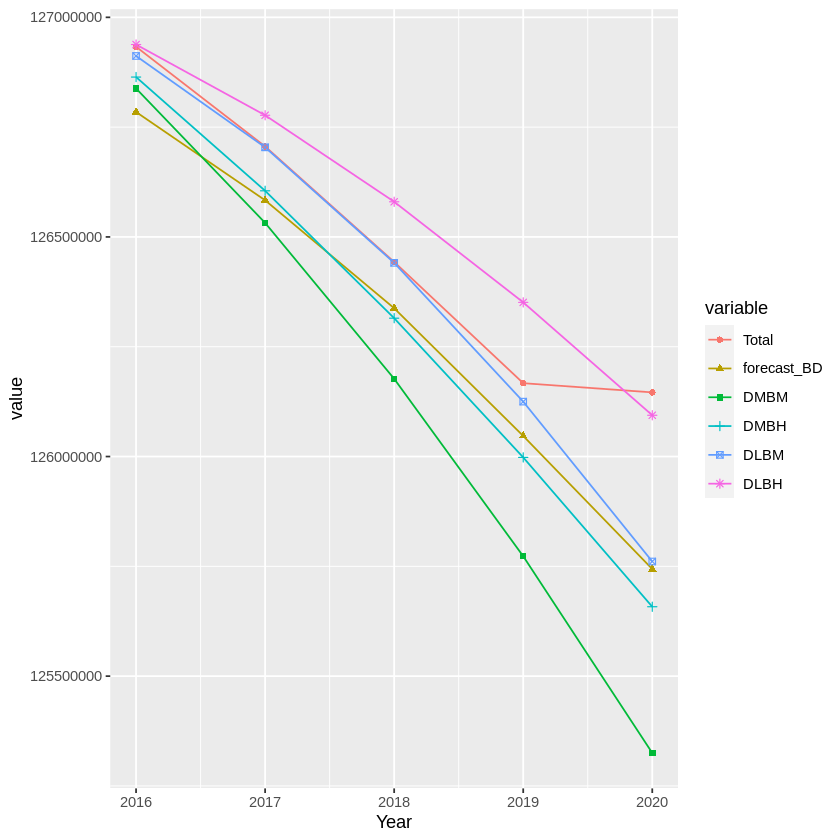

Plot variable not specified, automatically selected `.vars = Dr`


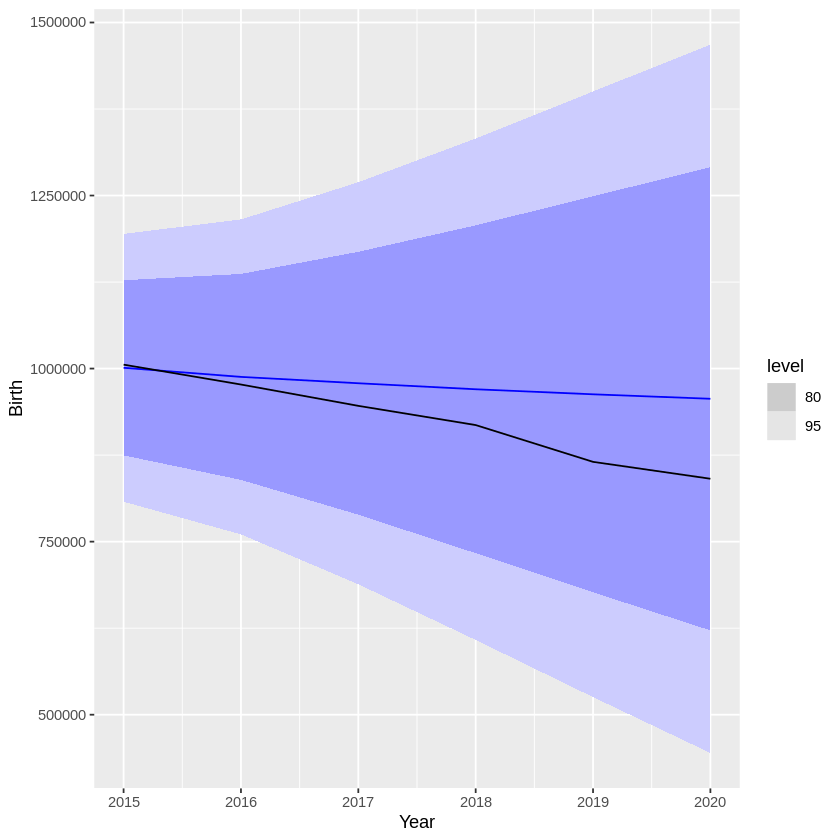

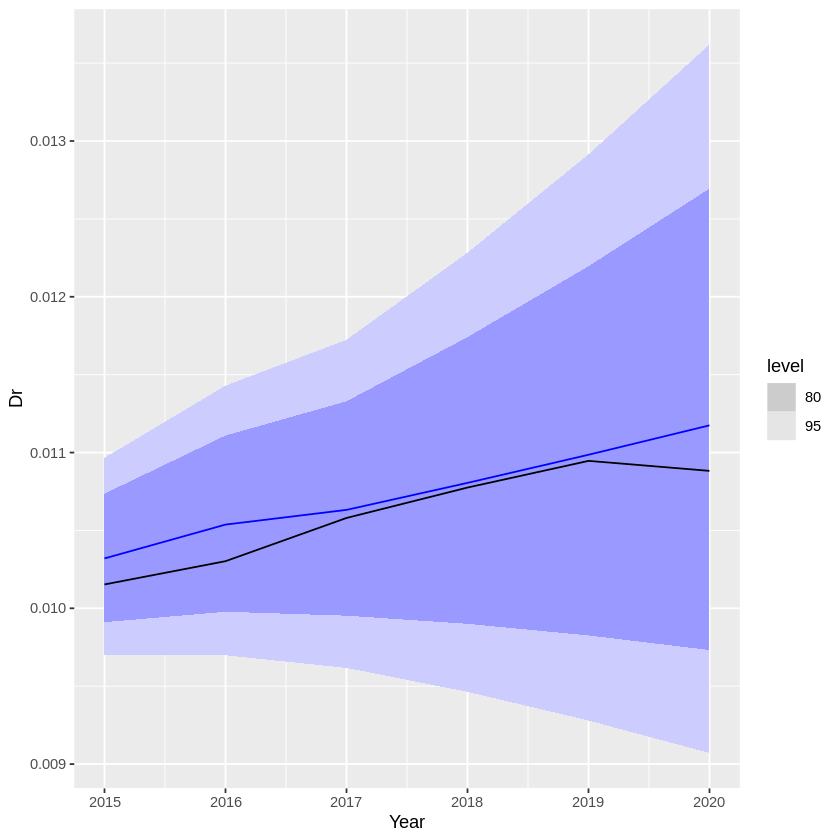

In [28]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) ->           # ＴＳＩＢＢＬＥライブラリに変換
ipss_test

pop_arima_f3[ ,1:2 ] |>
  inner_join( pop_test3, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test3
join_test3

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test3 |> 
  melt(id = "Year",
       measure = c( "Total",
                    "forecast_BD",
                    "DMBM",
                    "DMBH",
                    "DLBM",
                    "DLBH")) |>
  ggplot( aes(x = Year,
              y = value,
              shape = variable,
              colour = variable,
              group = variable )) +
  geom_line() +
  geom_point()

pop_test3 |>
  select( Year, Birth ) ->
  pop_testB

pop_arimaB_f |>
  filter( .model == "arimaB510" ) |>
  autoplot() +
  autolayer( pop_testB )

pop_test3 |>
  select( Year, Dr ) ->
  pop_testDr

pop_arimaDr_f |>
  filter( .model == "arimaDr024" ) |>
  autoplot() +
  autolayer( pop_testDr )

今度も少し低めに出てしまいました。  
死亡率の影響はわずかだったようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　[ Python_ARIMA_3 ](https://colab.research.google.com/drive/14Ypt-UupLji-O6UhD5rn4-spJzyB9CT3?usp=sharing) 
*   同じ事を状態空間モデルでやってみる。　->　[ R_StateSpace_3 ](https://colab.research.google.com/drive/1gtqBIsD3d4RAmLhStwuO-OLuRNCeMSiO?usp=sharing)
*   人口３区分の死亡率を使って推計する　->　[ R_ARIMA_4 ](https://colab.research.google.com/drive/1QphFr9OsyonZQlRDjsa0rYdg8BUGI3N9?usp=sharing)
